<a href="https://colab.research.google.com/github/mohamed-mkh15/Search-and-Sample-Return/blob/main/Search_and_Sample_Return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search and Sample Return

## The Perception Step


### Reading in Color Images

In order to navigate autonomously through the environment, we will use 320x160 pixel camera images to determine where it is possible to drive. In general, this can be a very complicated task, but in this case, it's simplified a bit.

![image](https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg)

Throughout the environment, the sand on the ground is very light in color and everything else in the environment is dark. All we have to do to determine where you can drive is to figure out where the areas of lighter color are. As an example of how to do this, we'll look at the above image using Python. The image could be downloaded here: https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg

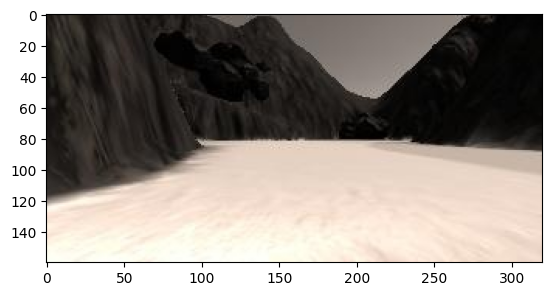

In [38]:
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# %matplotlib inline

# Define the filename, read and plot the image
# !wget "https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/sample.jpg"
filename = 'sample.jpg'
image = mpimg.imread(filename)
plt.imshow(image)
plt.show()

Exploreing what it's size and datatype are, as well as the minimum and maximum values in the array

In [39]:
# Import the "numpy" package for working with arrays
import numpy as np
print(image.dtype, image.shape, np.min(image), np.max(image))
# uint8 (160, 320, 3) 0 255

uint8 (160, 320, 3) 0 255


Size of the array is (160, 320, 3) meaning the image size is 160 pixels in the y-direction (height), 320 pixels in the x-direction (width) and it has 3 layers or "color channels".

The three color channels of the image are red, green and blue or "RGB" for short. The combination of intensity values across the three channels determines what color we see in the image.

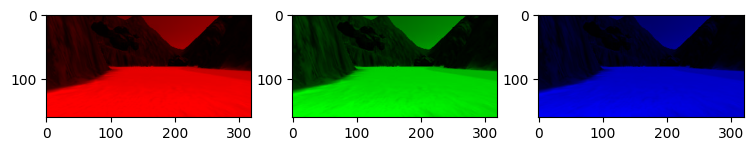

In [41]:
# Note: we use the np.copy() function rather than just saying red_channel = image
# because in Python, such a statement would set those two arrays equal to each other
# forever, meaning any changes made to one would also be made to the other!
red_channel = np.copy(image)
# Note: here instead of extracting individual channels from the image
# I'll keep all 3 color channels in each case but set the ones I'm not interested
# in to zero.
red_channel[:,:,[1, 2]] = 0 # Zero out the green and blue channels
green_channel = np.copy(image)
green_channel[:,:,[0, 2]] = 0 # Zero out the red and blue channels
blue_channel = np.copy(image)
blue_channel[:,:,[0, 1]] = 0 # Zero out the red and green channels
fig = plt.figure(figsize=(9,3)) # Create a figure for plotting
plt.subplot(131) # Initialize subplot number 1 in a figure that is 3 columns 1 row
plt.imshow(red_channel) # Plot the red channel
plt.subplot(132) # Initialize subplot number 2 in a figure that is 3 columns 1 row
plt.imshow(green_channel)  # Plot the green channel
plt.subplot(133) # Initialize subplot number 3 in a figure that is 3 columns 1 row
plt.imshow(blue_channel)  # Plot the blue channel
plt.show()

### Color Thresholding

We can see now that, while the mountains are relatively dark (low intensity values) in all three color channels, both the ground and the sky are brighter (higher intensity) in the red, green and blue channels. However, in all cases it looks like the ground is a bit brighter than the sky, such that it should be possible to identify pixels associated with the ground using a simple color threshold.

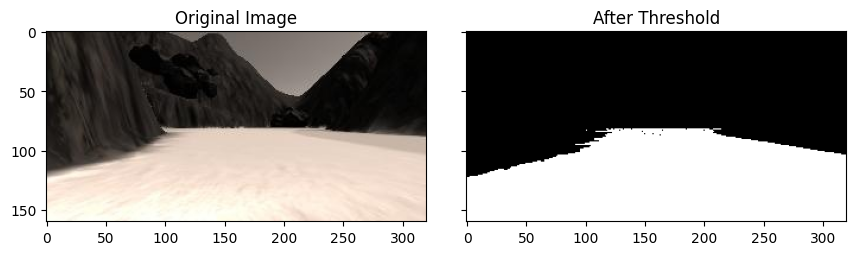

In [48]:
# Define color sealection criteria
###### TODO: MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 180
green_threshold = 180
blue_threshold = 180
######
rgb_threshold = (red_threshold, green_threshold, blue_threshold)

# Define a function to perform a color threshold
def color_thresh(img, rgb_thresh=(0, 0, 0)):
    ###### TODO:
    # Create an empty array the same size in x and y as the image
    # but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's
    # where threshold was exceeded
    up_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Now update the value of color_select with making the indecies refered
    # to by up_thresh have a value of 1
    color_select[up_thresh]=1
    # Return the single-channel binary image
    return color_select

# pixels above the thresholds
colorsel = color_thresh(image, rgb_thresh=rgb_threshold)

# Display the original image and binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=12)

ax2.imshow(colorsel, cmap='gray')
ax2.set_title('After Threshold', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.show() # Uncomment if running on your local machine

## Perspective Transform


Perspective transforms involve some complicated geometry but here we'll use the OpenCV functions cv2.getPerspectiveTransform() and cv2.warpPerspective() to do the heavy lifting (for more on this and other geometric transforms you can do with OpenCV, check out this page: https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html).

So, we'll want to perform the following steps:

- Define 4 source points, in this case, the 4 corners of a grid cell in the image above.
- Define 4 destination points (must be listed in the same order as source points!).
- Use cv2.getPerspectiveTransform() to get M, the transform matrix.
- Use cv2.warpPerspective() to apply M and warp your image to a top-down view.

First, we need to select four points in our "source" image and map them to four points in our "destination" image, which will be the top-down view. An example image can be found here: https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/example_grid1.jpg.

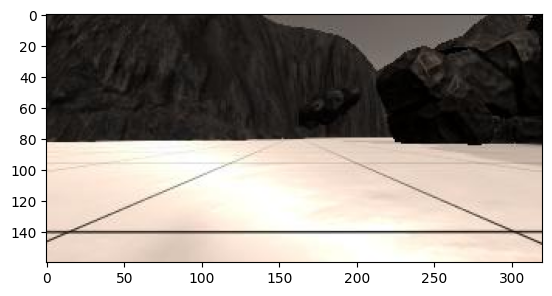

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Uncomment the next line for use in a Jupyter notebook
# This enables the interactive matplotlib window
#%matplotlib notebook

# !wget "https://s3-us-west-1.amazonaws.com/udacity-robotics/Rover+Unity+Sims/Rover+Example+Images/example_grid1.jpg"
image = mpimg.imread('example_grid1.jpg')
plt.imshow(image)
plt.show()

In [57]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
matplotlib.pyplot.switch_backend(newbackend)

In [14]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib notebook
%matplotlib widget

In [12]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

ax.imshow(image)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>